In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# DL and data processing:
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
import pandas as pd

#progress bars
from tqdm.notebook import tqdm, trange, tnrange

# plotting params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(1234)
torch.manual_seed(1234);

# make model notebook device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class TextFromPandas(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.n = 0
             
    def __getitem__(self, idx):
        text = pd.Series(self.dataframe.iloc[idx, :-1], dtype="string")
        label = self.dataframe.iloc[idx, -1]
        return label, " ".join(text.tolist())
    
    def __len__(self):
        return len(self.dataframe)
    
    def __iter__(self):
        return self;
    
    def __next__(self):
        if self.n < len(self):
            result = self[self.n]
            self.n += 1
            return result
        else:
            raise StopIteration
            

In [3]:
tweet_df = pd.read_csv('data/train.csv').drop(['id'], axis=1)
tweet_df.fillna(value="<unk>", inplace=True)
dataset = TextFromPandas(tweet_df)
tweet_df.head(5)

,keyword,location,text,target
0,<unk>,<unk>,Our Deeds are the Reason of this #earthquake M...,1
1,<unk>,<unk>,Forest fire near La Ronge Sask. Canada,1
2,<unk>,<unk>,All residents asked to 'shelter in place' are ...,1
3,<unk>,<unk>,"13,000 people receive #wildfires evacuation or...",1
4,<unk>,<unk>,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
dataset[0], dataset[-1]

((1,
  '<unk> <unk> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'),
 (1,
  '<unk> <unk> The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'))

In [5]:
# Build vocabulary from tweets plus AG_NEWS
import itertools
from torchtext.datasets import AG_NEWS

# split an input string into tokens
tokenizer = get_tokenizer('basic_english')

# generator that tokenizes each element of an iterator into a list
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

#join tweets dataset with AG_NEWS dataset to get larger vocabulary
all_text = itertools.chain(dataset, AG_NEWS(split='train'))

# build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(all_text), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [6]:
# Setup collate function and dataloader
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.float64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [7]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [8]:
def train_one_epoch(model, opt, criterion, lr, trainloader):
    model.to(device)
    model.train()
    
    running_tl = 0
    
    for (label, text, offsets) in trainloader:
        
        opt.zero_grad()
        
        label, text = label.to(device), text.to(device)
        label = label.reshape(label.size()[0], 1)
        
        output = model(text, offsets)
        loss = criterion(output, label)

        running_tl += loss.item()
        loss.backward()
        opt.step()
        
    return running_tl
        
def validate_one_epoch(model, opt, criterion, lr, validloader):
    
    running_vl = 0
    
    model.eval()
    with torch.no_grad():
        for (label, text, offsets) in validloader:
            label = label.reshape(label.shape[0], 1)
            output = model(text, offsets)
            loss = criterion(output, label)
            running_vl += loss.item()
            
    return running_vl
    

def train_model(model, opt, criterion, epochs, trainload, testload=None, lr=1e-3):
    
    avg_tl_per_epoch = []
    avg_vl_per_epoch = []
    
    for e in trange(epochs):
        running_tl = train_one_epoch(model, opt, criterion, lr, trainload)
        avg_tl_per_epoch.append(running_tl / len(trainload))
        if testload:
            running_vl = validate_one_epoch(model, opt, criterion, lr, validloader)
            avg_vl_per_epoch.append(running_vl / len(testload))
    
    return avg_tl_per_epoch, avg_vl_per_epoch
            

In [9]:
# create training and testing datasets
np.random.seed(1234)
train_split = int(0.8 * len(tweet_df))
idx = np.arange(0, len(tweet_df))
np.random.shuffle(idx)

train_idx = idx[:train_split]
test_idx  = idx[train_split:]

train_data = TextFromPandas(tweet_df.iloc[train_idx])
test_data = TextFromPandas(tweet_df.iloc[test_idx])

trainloader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
validloader = DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=collate_batch)

In [10]:
# Instantiate a model
vocab_size = len(vocab)
num_classes = 1
emb_size = 64

model = TextClassificationModel(vocab_size, emb_size, num_classes)

In [11]:
# Setup training
epochs = 100
lr = 1e-2

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

loss = train_model(model, optimizer, criterion, epochs, trainloader, validloader, lr=lr)

  0%|          | 0/100 [00:00<?, ?it/s]

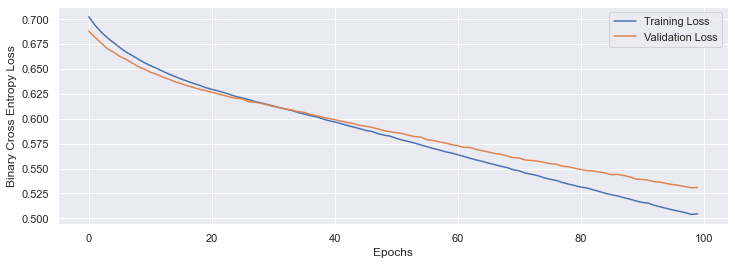

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Epochs")
ax.set_ylabel("Binary Cross Entropy Loss")
sns.lineplot(data=loss[0], ax=ax, label="Training Loss")
sns.lineplot(data=loss[1], ax=ax, label="Validation Loss")
plt.legend()
plt.show()